In [ ]:
!pip install git+https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git to /tmp/pip-req-build-_rwz9fwv
  Running command git clone --filter=blob:none --quiet https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git /tmp/pip-req-build-_rwz9fwv
  Resolved https://github.com/AdrianUrbanski/Cell_nuclei_segmentation.git to commit bcc5e2208344be5fbfba5b736f96be167c82a65b
  Preparing metadata (setup.py) ... done
  Created wheel for src: filename=src-0.1.0-py3-none-any.whl size=4392 sha256=ebdb27d7203989ea116eb3e62704763ca049bb6d6f8b8c1e076a6e4e2b6cf3d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-exogm3wl/wheels/05/26/e4/331bb032dbc294e55b1e141b7a6595a14c0e57d6c05184dc51
Successfully built src


In [ ]:
!pip install pytorch-lightning pytorch-toolbelt imagecodecs stardist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 13.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.data import FullImageDataset
from src.metrics import calculate_dice, calculate_iou, calculate_map
from src.utils import apply_watershed, map_mask

# Create dataset

In [ ]:
batch_size = 50
PATH = '/content/drive/MyDrive/Cell_segmentation/rescaled'
train_dataset = FullImageDataset(
    f'{PATH}/train/img',
    f'{PATH}/train/mask'
)

val_dataset = FullImageDataset(
    f'{PATH}/val/img',
    f'{PATH}/val/mask'
)

test_dataset = FullImageDataset(
    f'{PATH}/test/img',
    f'{PATH}/test/mask'
)

Succesfully loaded 38 images
Succesfully loaded 4 images
Succesfully loaded 37 images


# Find threshold maximizing dice

In [ ]:
def get_dice(threshold, dataset, normalize=True):
    dice = []
    for img, mask in dataset:
        if normalize:
            img = img/np.max(img)
        pred = img > threshold
        dice.append(calculate_dice(mask.astype(bool), pred.astype(bool)))
    return np.mean(dice)

In [ ]:
values = []
for threshold in range(100):
    values.append(get_dice(threshold/100, train_dataset, normalize=True))

In [ ]:
threshold = np.argmax(values)/100

print(f"train dice: {get_dice(threshold, train_dataset)}")
print(f"val dice: {get_dice(threshold, val_dataset)}")

train dice: 0.9120776932149618
val dice: 0.9019928804386679


# Evaluate model

In [ ]:
def predict(image, mask, threshold):
    image /= np.max(image)
    pred = (image[0] > threshold).astype(int)
    pred = apply_watershed(image[0] > threshold, min_distance=10)
    pred = map_mask(mask[0], pred)
    return pred

## Calculate metrics

In [ ]:
def evaluate(threshold, dataset):
    metrics = []
    for img, mask in dataset:
        pred = predict(img, mask, threshold)
        mask = np.squeeze(mask)
        metrics.append({
            'dice': calculate_dice(mask, pred),
            'iou': calculate_iou(mask, pred),
            'map': calculate_map(mask, pred),
            })
    return pd.DataFrame(metrics)

In [ ]:
results = evaluate(threshold, train_dataset)
results.describe()

,dice,iou,map
count,38.000000,38.000000,38.000000
mean,0.910457,0.843903,0.736065
std,0.076434,0.121325,0.182648
min,0.720576,0.563204,0.212177
25%,0.866339,0.764196,0.602866
50%,0.950462,0.905606,0.774562
75%,0.972583,0.946630,0.882630
max,0.981646,0.963954,0.964825


In [ ]:
results = evaluate(threshold, val_dataset)
results.describe()

,dice,iou,map
count,4.000000,4.000000,4.000000
mean,0.899680,0.819485,0.635214
std,0.040258,0.066759,0.203198
min,0.851218,0.740975,0.441568
25%,0.883045,0.791058,0.527025
50%,0.899150,0.816823,0.590678
75%,0.915785,0.845250,0.698866
max,0.949203,0.903317,0.917931


In [ ]:
results = evaluate(threshold, test_dataset)
results.describe()

,dice,iou,map
count,37.000000,37.000000,37.000000
mean,0.843743,0.745117,0.648143
std,0.113829,0.161273,0.232310
min,0.593254,0.421721,0.063847
25%,0.796908,0.662383,0.477631
50%,0.878963,0.784062,0.656703
75%,0.928342,0.866267,0.848159
max,0.973706,0.948759,0.939104


## Plot results

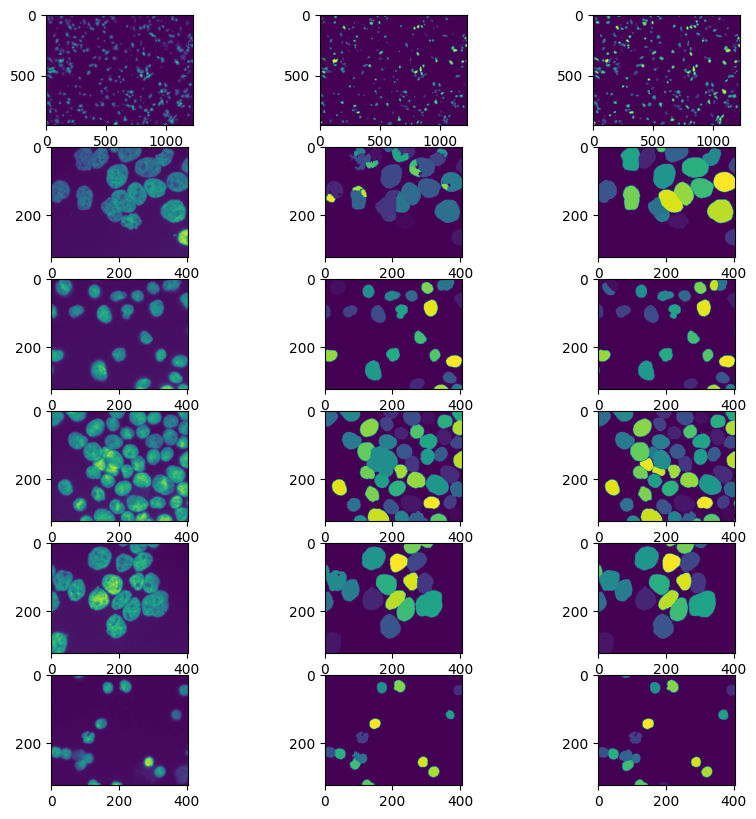

In [ ]:
num_rows = 6

img, mask = train_dataset[0]
fig, axes = plt.subplots(num_rows, 3, figsize=(10, 10))

for row in range(num_rows):
    img, mask = train_dataset[row]
    pred = predict(img, mask, threshold)
    axes[row, 0].imshow(img[0])
    axes[row, 1].imshow(pred)
    axes[row, 2].imshow(mask[0])